In [1]:
import sagemaker
from sagemaker import get_execution_role
import io
import boto3

import json
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
# import accimage
from PIL import Image
import random

In [10]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
print(role)
s3 = boto3.resource('s3')
bucket_name = 'schen5-bucket03'
bucket = s3.Bucket(bucket_name)
prefix = 'affordance_data'

arn:aws:iam::226452194943:role/service-role/AmazonSageMaker-ExecutionRole-20210425T015541


In [3]:
def default_loader(path):
    img_bytes = s3.Object(bucket_name, path).get()['Body'].read()
    # e.g. path: 'train/21JBED3YWoL._AC_.png'
    return Image.open(io.BytesIO(img_bytes)).convert('RGB')

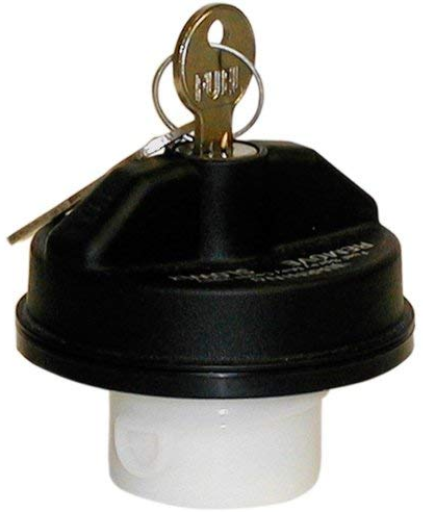

In [11]:
default_loader(f'{prefix}/test/41K6PcPGVCL._AC_.png')

In [12]:
img_bytes = s3.Object(bucket_name, f'{prefix}/train/21JBED3YWoL._AC_.png').get()['Body'].read()
print(Image.open(io.BytesIO(img_bytes)))

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x189 at 0x7F6FFC263C50>


In [ ]:
for object_summary in bucket.objects.filter(Prefix=prefix):
    key = object_summary.key
    print(key)
    if key == 'train/.DS_Store':
        continue
    file_stream = io.BytesIO()
    object = bucket.Object(key)
    object.download_fileobj(file_stream)
    img = mpimg.imread(file_stream, 'jpg')
    im = Image.fromarray((img * 255).astype(np.uint8)).convert('RGB')
    break

In [13]:
img_bytes = s3.Object(bucket_name, f'{prefix}/train/21JBED3YWoL._AC_.png').get()['Body'].read()

In [14]:
image = Image.open(io.BytesIO(img_bytes))

In [15]:
object_summary.key[len(prefix)+1:-4]

NameError: name 'object_summary' is not defined

In [ ]:
print(img.shape)
im = Image.fromarray((img * 255).astype(np.uint8)).convert('RGB')
im

In [22]:
def make_dataset(directory, labels_dic):
    images = []
    for object_summary in bucket.objects.filter(Prefix=directory):
        path = object_summary.key
        fname = object_summary.key[len(directory)+1:-4]
        try:
            item = (path, labels_dic[fname])
            images.append(item)
        except:
            continue
    print(len(images))
    random.Random(4).shuffle(images)
    return images

In [ ]:
response = s3.Object(bucket_name, 'labels.json').get()['Body']
labels_dic = json.loads(response.read())
# labels['21JBED3YWoL._AC_']

In [25]:
samples = make_dataset(f'{prefix}/train', make_labels())

678


In [26]:
samples

[('affordance_data/train/71rs5RhZFVL._AC_SL1500_.png',
  [60.857142857142854, 81.33333333333333, 47.0, 46.4, 80.08, 256]),
 ('affordance_data/train/61RLP174fhL._AC_SL1001_.png',
  [72.0, 85.33333333333333, 44.833333333333336, 46.0, 59.78260869565217, 64]),
 ('affordance_data/train/61NclicU26L._AC_SL1080_.png',
  [40.875, 82.77777777777777, 57.0, 50.0, 72.81818181818181, 256]),
 ('affordance_data/train/51C6xy0qQ+L._AC_SL1200_.png',
  [74.28571428571429, 59.875, 31.625, 43.125, 24.580645161290324, 64]),
 ('affordance_data/train/71g2SJXFd0L._AC_SL1500_.png',
  [76.6, 70.4, 20.0, 33.6, 95.1, 128]),
 ('affordance_data/train/61QifD4jpQL._AC_SL1500_.png',
  [80.5, 62.857142857142854, 49.25, 45.25, 57.32258064516129, 128]),
 ('affordance_data/train/41tuT3dEvOL._SL1001_.png',
  [58.375,
   88.66666666666667,
   54.44444444444444,
   39.375,
   76.73529411764706,
   256]),
 ('affordance_data/train/61ay6KOoLbL._AC_SL1400_.png',
  [54.857142857142854,
   67.77777777777777,
   58.44444444444444,
  

In [24]:
def make_labels():
    def mean(scores):
        return np.mean([v for v in scores.values()])
    def mean2(scores):
        out = []
        for v in scores.values():
            out += v
        return np.mean(out)
    response = s3.Object(bucket_name, f'{prefix}/labels.json').get()['Body'].read()
    labels_dic = json.loads(response)
    out = {}
    for file_name, scores in labels_dic.items():
        pinch = mean(scores['pinch'])
        clench = mean(scores['clench'])
        poke = mean(scores['poke'])
        palm = mean(scores['palm'])
        familiarity = mean2(scores['familiarity'])
        size = scores['size']
        out[file_name] = [pinch, clench, poke, palm, familiarity, size]
    return out

In [ ]:
# make_labels()

In [ ]:
[s[1] for s in samples]

In [17]:
import os

In [21]:
files = [f for f in os.listdir('./././.')]
for f in files:
    print(f)

split-data.py
untitled.py
.git
__pycache__
run-sagemaker.ipynb
.ipynb_checkpoints
ckpt
train.py
test-sagemaker.ipynb


In [34]:
class DatasetFolder():
    def __init__(self, directory):
        samples = make_dataset(directory, make_labels())
        self.loader = default_loader
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        target = torch.Tensor(target)
        return sample, target

    def __len__(self):
        return len(self.samples)

def train_val_idx(n, l):
    assert n >= 0
    start = int((l*0.2*n)%l)
    end = int((l*0.2*(n+1))%l)
    return start, end

def make_splitted_images(image_datasets, n):
    s, e = train_val_idx(n, len(image_datasets))

    if s < e:
        train = copy.deepcopy(image_datasets)
        train.samples = image_datasets.samples[:s]+image_datasets.samples[e:]
        train.targets = image_datasets.targets[:s]+image_datasets.targets[e:]

        val = copy.deepcopy(image_datasets)
        val.samples = image_datasets.samples[s:e]
        val.targets = image_datasets.targets[s:e]
    else:
        train = copy.deepcopy(image_datasets)
        train.samples = image_datasets.samples[e:s]
        train.targets = image_datasets.targets[e:s]

        val = copy.deepcopy(image_datasets)
        val.samples = image_datasets.samples[:e]+image_datasets.samples[s:]
        val.targets = image_datasets.samples[:e]+image_datasets.targets[s:]

    return {'train': train, 'val': val}

In [35]:
image_datasets = make_splitted_images(DatasetFolder(f'{prefix}/train'), 0)

678


In [31]:
import copy

In [36]:
image_datasets

{'train': <__main__.DatasetFolder at 0x7f6ffd7a3048>,
 'val': <__main__.DatasetFolder at 0x7f702c5beac8>}